In [38]:
%matplotlib inline
import pandas as pd
import numpy as np
from skimage.io import imsave
from machinedesign.autoencoder.interface import load
from machinedesign.viz import grid_of_images_default, horiz_merge
from lightjob.cli import load_db
import keras.backend as K
import matplotlib.pyplot as plt
from IPython.display import Image
from fluentopt.utils import flatten_dict
import seaborn as sns
from scipy.stats import binned_statistic
pd.options.display.max_columns = 100
sns.set_style('white')

def show_several(df):
    for j in df.index:
        print(j)
        show_one(j)
def show_one(j):
    try:
        X = np.load('../results/jobs/{}/gen/generated.npz'.format(j))['generated'][0:100]
    except Exception:
        return
    X = grid_of_images_default(X)
    imsave('out.png', X)
    im = Image('out.png')
    display(im)

In [375]:
df_full = pd.read_csv('../../export/hypers.csv')
df_full = df_full.set_index('job_id')
#df_full['letters'] = 0.5 * df_full['letters_object'] + 0.5 * df_full['letters_diversity']

In [379]:
labels = [
    'emnist_digits_count',
    'emnist_letters_count',
    'digits_count', 
    'letters_count', 
    'digits_objectness', 
    'letters_objectness', 
    'digits_and_letters_objectness', 
    'emnist_objectness',
    'ratio_unique',
    'innovative',
    'existing',
    'noisy',
    'recons_ratio_hwrt',
    'recons_ratio_digits',
]

d = df_full[labels].corr()
def m(val):
    color = 'yellow' if abs(val) > 0.8 else 'red' if abs(val) < 0.2 else 'white'
    return 'background-color: %s' % color

d = d.style.applymap(m)
d

,emnist_digits_count,emnist_letters_count,digits_count,letters_count,digits_objectness,letters_objectness,digits_and_letters_objectness,emnist_objectness,ratio_unique,innovative,existing,noisy,recons_ratio_hwrt,recons_ratio_digits
emnist_digits_count,1,-0.23483,0.5255,-0.468059,0.390713,0.198077,-0.0262494,0.308614,0.1942,0.173994,0.368314,-0.482991,-0.100047,0.212078
emnist_letters_count,-0.23483,1,-0.250408,0.352242,0.427953,0.540464,0.70224,0.449923,0.695972,0.339338,-0.638436,0.145814,0.418786,0.341235
digits_count,0.5255,-0.250408,1,-0.908417,0.463885,0.345577,-0.0840875,0.422827,0.16139,0.460292,0.689802,-0.897972,0.161531,0.448496
letters_count,-0.468059,0.352242,-0.908417,1,-0.380486,-0.261214,0.164145,-0.342722,-0.0601016,-0.401507,-0.822788,0.919946,-0.124274,-0.382607
digits_objectness,0.390713,0.427953,0.463885,-0.380486,1,0.911601,0.671254,0.950801,0.876319,0.815293,-0.154056,-0.64625,0.40715,0.673564
letters_objectness,0.198077,0.540464,0.345577,-0.261214,0.911601,1,0.813666,0.947725,0.847799,0.915281,-0.318177,-0.558219,0.57494,0.697328
digits_and_letters_objectness,-0.0262494,0.70224,-0.0840875,0.164145,0.671254,0.813666,1,0.714854,0.803982,0.575515,-0.609311,-0.0632667,0.355723,0.377163
emnist_objectness,0.308614,0.449923,0.422827,-0.342722,0.950801,0.947725,0.714854,1,0.841306,0.885613,-0.217047,-0.625524,0.47089,0.697506
ratio_unique,0.1942,0.695972,0.16139,-0.0601016,0.876319,0.847799,0.803982,0.841306,1,0.646908,-0.405422,-0.314193,0.40697,0.56688
innovative,0.173994,0.339338,0.460292,-0.401507,0.815293,0.915281,0.575515,0.885613,0.646908,1,-0.162767,-0.69726,0.643904,0.726124


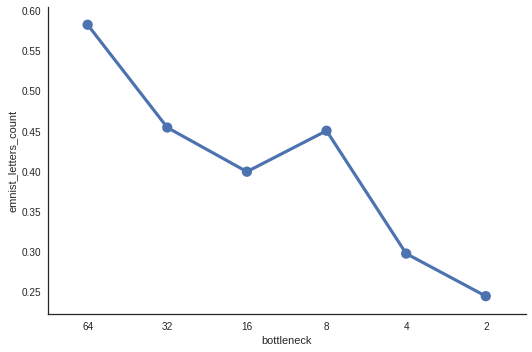

In [331]:
df = df_full
df = df[df['sampler'] == 'mnist_capacity']
df  = df[df['nb_layers']==3]
df = df.sort_values(by='bottleneck', ascending=False)
sns.factorplot(x='bottleneck', y='emnist_letters_count', data=df, order=[64, 32, 16, 8, 4, 2], size=5, aspect=1.5)
#show_several(df)
#col = 'bottleneck'
#fig, ax = plt.subplots(figsize=(10, 5))
#df.plot(col, 'letters_objectness', ax=ax, color='blue')
#df.plot(col, 'letters_count', ax=ax, color='green')
#df.plot(col, 'letters_diversity', ax=ax, color='red')

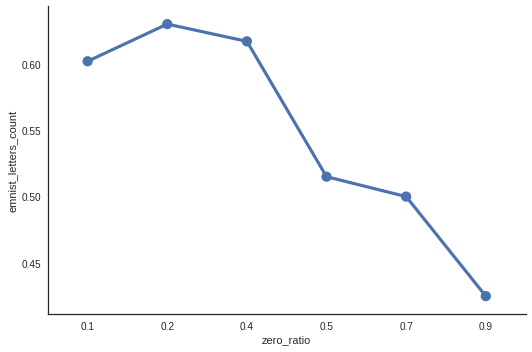

In [335]:
df = df_full
df = df[df['sampler'] == 'mnist_deep_kchannel']
df = df[df['nb_layers']==3]
#df = df[df['stride'] == 1]
#df = df[df['zero_ratio']!=0.4]
df = df.sort_values(by='zero_ratio')
col = 'zero_ratio'
#fig, ax = plt.subplots(figsize=(10, 5))
#df.plot(col, 'letters_object', ax=ax, color='blue')
#df.plot(col, 'letters_count', ax=ax, color='green')
#df.plot(col, 'letters_diversity', ax=ax, color='red')
sns.factorplot(x='zero_ratio', y='emnist_letters_count', data=df, size=5, aspect=1.5)
#show_several(df)

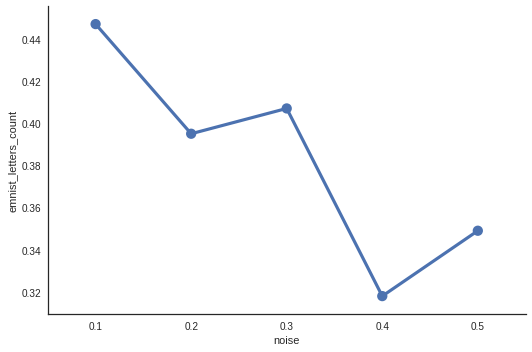

In [359]:
df = df_full
df = df[df['sampler'] == 'mnist_noise']
df = df[df['nb_layers']==3]
df = df[df['noise']<=0.5]
df = df.sort_values(by='noise')
sns.factorplot(x='noise', y='emnist_letters_count', data=df, size=5, aspect=1.5)
#col = 'noise'
#fig, ax = plt.subplots(figsize=(10, 5))
#df.plot(col, 'letters_object', ax=ax, color='blue')
#df.plot(col, 'letters_count', ax=ax, color='green')
#df.plot(col, 'letters_diversity', ax=ax, color='red')
#show_several(df)

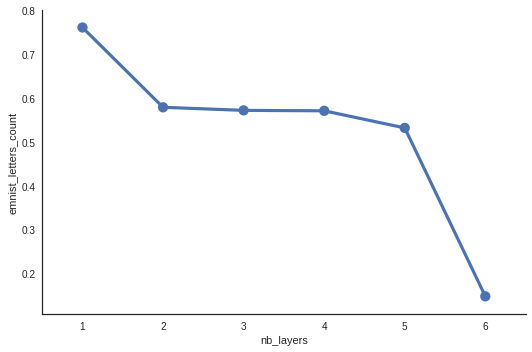

In [369]:
df = df_full
df = df[df['sampler'] == 'mnist_deep']
df = df[df['stride']==1]
df = df.sort_values(by='nb_layers')
sns.factorplot(x='nb_layers', y='emnist_letters_count', data=df, size=5, aspect=1.5)
#fig, ax = plt.subplots(figsize=(10, 5))
#df.plot('nb_layers', 'letters_object', ax=ax, color='blue')
#df.plot('nb_layers', 'letters_count', ax=ax, color='green')
#df.plot('nb_layers', 'letters_diversity', ax=ax, color='red')
#df.plot('nb_layers', 'letters_objectness', kind='scatter', ax=ax, s=50)

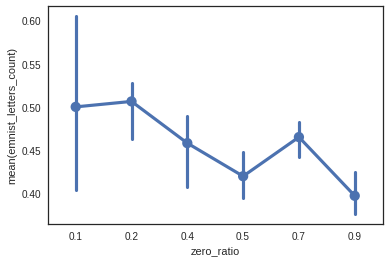

In [368]:
df = df_full
df = df[df['sampler'] == 'mnist_deep_kchannel_stride']
df = df[df['nb_layers']==3]
#df = df[df['stride'] == 2]
df = df.sort_values(by='zero_ratio')
sns.pointplot(x='zero_ratio', y='emnist_letters_count', data=df, size=80)
#show_several(df)

In [380]:
df = df_full
df = df[df['sampler'] == 'mnist_deep']
df = df[df['stride']==1]
df = df[df['nb_layers'] == 3]
#show_several(df)

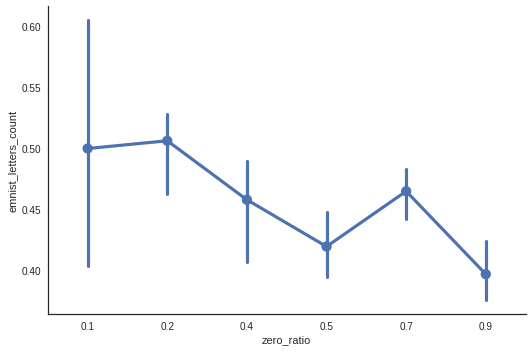

In [398]:
df = df_full
df = df[df['nb_layers']==3]
df = df[df['sampler'] == 'mnist_deep_kchannel']
sns.factorplot(x='zero_ratio', y='emnist_letters_count', data=df, size=5, aspect=1.5)

165


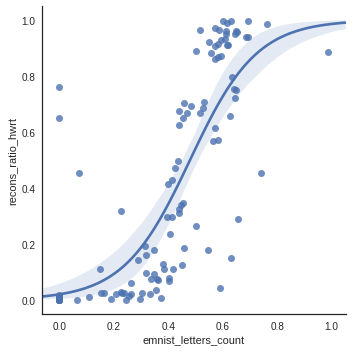

In [450]:
#df_full.plot('recons_ratio_hwrt', 'emnist_letters_count', kind='scatter')
df = df_full
#df = df[df['sampler'] == 'mnist_deep']
df = df[df['nb_layers']>=3]
sns.lmplot('emnist_letters_count', 'recons_ratio_hwrt', data=df, logistic=True)
print(len(df))

In [ ]:
df = df_full
#df = df[df['sampler'] == 'mnist_noise']
df = df[df['nb_layers']==3]
sns.lmplot('noise', 'emnist_letters_count', data=df)